In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from matplotlib import figure as fig
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from matplotlib import pyplot as plt

np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.11.0


In [2]:
from google.colab import files
uploaded = files.upload()

Saving JNJ (1).csv to JNJ (1).csv


In [4]:
import io
df = pd.read_csv(io.BytesIO(uploaded['JNJ (1).csv']))
df['Date'] = pd.to_datetime(df['Date'])
df = df[['Date', 'Close']]
stock_price = df
stock_price = stock_price.set_index(stock_price.columns[0])
stock_price

,Close
Date,
1985-12-09,3.164063
1985-12-10,3.164063
1985-12-11,3.179688
1985-12-12,3.250000
1985-12-13,3.335938
...,...
2022-12-21,177.679993
2022-12-22,177.029999
2022-12-23,177.479996


In [5]:
df.dtypes

Date     datetime64[ns]
Close           float64
dtype: object

In [29]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Johnson and Johnson Stock Price 1985-2022')
fig.show()


from google.colab import drive
drive.mount('/content/drive')
images_dir = '//content/drive/MyDrive/Colab Notebooks/try'
plt.savefig(f"{images_dir}/jnjdatsetplot.svg", dpi=300, bbox_inches='tight')
files.download("jnjdatsetplot.svg")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [32]:
print('Missing values:', stock_price.isnull().sum().sum()) 


# checking missing values
stock_price = stock_price.dropna() 


# dropping missing valies
print('....Dropped Missing value row....\n')

# checking missing values
print('Rechecking Missing values:', stock_price.isnull().sum()) 


Missing values: 0
....Dropped Missing value row....

Rechecking Missing values: Close    0
dtype: int64


In [33]:
stock_price.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Close,9340.0,61.435573,47.545342,2.984375,14.53125,57.299999,89.952501,186.009995


Box plot Visualization


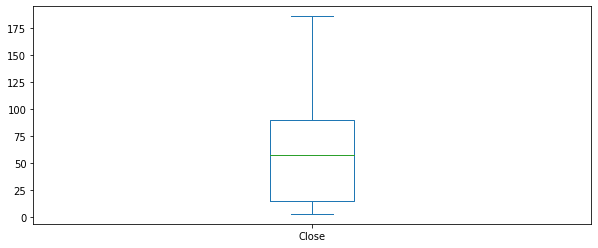

In [36]:
# Generate Boxplot
print("Box plot Visualization")
stock_price.plot(kind = "box", figsize = (10, 4))
plt.show()

Histogram Visualization:


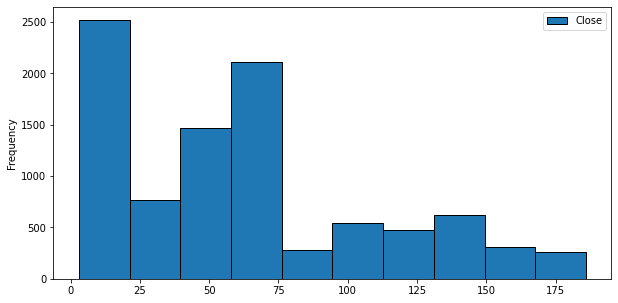

In [37]:
# Generate Histogram
print( "Histogram Visualization:")
stock_price.plot( kind = "hist", edgecolor = "black", figsize = (10,5))
plt.show()

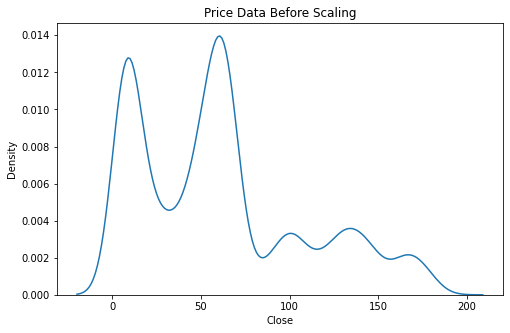

In [38]:
import seaborn as sns
fig, ax1 = plt.subplots(ncols = 1, figsize = (8,5))
ax1.set_title("Price Data Before Scaling")
sns.kdeplot(stock_price["Close"], ax = ax1 )
plt.show()

In [39]:
train_size = int(len(stock_price) * 0.95)
test_size = len(stock_price) - train_size
train, test = stock_price.iloc[0:train_size], stock_price.iloc[train_size:len(stock_price)]
print ("Train Shape:", train.shape)
print("Test shape:", test.shape)

Train Shape: (8873, 1)
Test shape: (467, 1)


In [40]:
# Data Standardization
robust = RobustScaler(quantile_range = (25, 75)).fit(train[["Close"]])
train["Close"] = robust.transform(train[["Close"]])
test["Close"] = robust.transform(test[["Close"]])

<ipython-input-40-3ee731011db6>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-40-3ee731011db6>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [41]:
#helper function
def create_dataset(X, y, time_steps=1):
    a, b = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)]
        a.append(v)
        b.append(y.iloc[i + time_steps])
    return np.array(a), np.array(b)

    # Now we will create sequences with 30 days of historical Data
n_steps = 30

# reshape to 3D [n_samples, n_steps, n_features]
X_train, y_train = create_dataset(train[["Close"]], train["Close"],n_steps)
X_test, y_test = create_dataset(test[["Close"]], test['Close'], n_steps)

print ("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (8843, 30, 1)
X_test shape: (437, 30, 1)


In [42]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
tf.keras.layers.RepeatVector(1)


In [43]:
units = 64
dropout = 0.20
optimizer = "adam"
loss = 'mae'
epochs = 50

model = keras.Sequential()
model.add(keras.layers.LSTM(units = units, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(rate=dropout))
model.add(tf.keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units = units, return_sequences = True))
model.add(keras.layers.Dropout(rate=dropout))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss = loss, optimizer = optimizer)
history = model.fit(X_train, y_train, epochs = epochs, batch_size = 32, validation_split = 0.1, shuffle = False)

Epoch 1/50
249/249 [==============================] - 18s 52ms/step - loss: 0.0978 - val_loss: 0.1343
Epoch 2/50
249/249 [==============================] - 12s 48ms/step - loss: 0.0638 - val_loss: 0.1417
Epoch 3/50
249/249 [==============================] - 10s 39ms/step - loss: 0.0582 - val_loss: 0.1737
Epoch 4/50
249/249 [==============================] - 11s 43ms/step - loss: 0.0547 - val_loss: 0.0752
Epoch 5/50
249/249 [==============================] - 11s 46ms/step - loss: 0.0617 - val_loss: 0.0727
Epoch 6/50
249/249 [==============================] - 11s 46ms/step - loss: 0.0594 - val_loss: 0.0688
Epoch 7/50
249/249 [==============================] - 11s 42ms/step - loss: 0.0588 - val_loss: 0.0748
Epoch 8/50
249/249 [==============================] - 10s 41ms/step - loss: 0.0662 - val_loss: 0.0700
Epoch 9/50
249/249 [==============================] - 11s 46ms/step - loss: 0.0691 - val_loss: 0.0815
Epoch 10/50
249/249 [==============================] - 11s 46ms/step - loss: 0.069

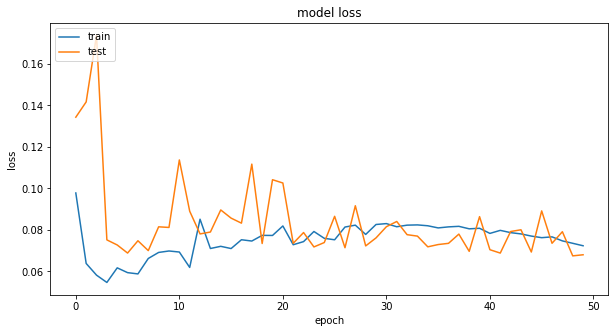

In [44]:
#history for loss

plt.figure(figsize = (10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

277/277 [==============================] - 6s 15ms/step
Training loss: 0.1519740444785689



<Figure size 720x360 with 0 Axes>

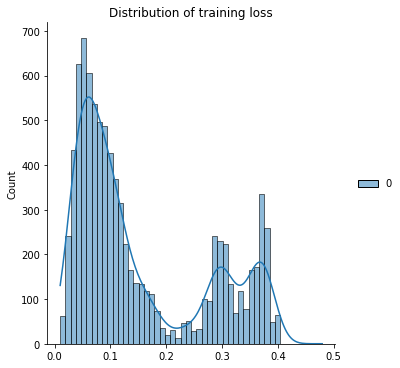

In [45]:
train_pred = model.predict(X_train)
train_loss = (np.mean(np.abs(train_pred - X_train), axis = 1))
avg_loss = train_loss.mean()
print("Training loss:", avg_loss), print()

plt.figure(figsize = (10, 5))
sns.displot(train_loss, bins = 50, kde = True)
plt.title('Distribution of training loss')
plt.show()

277/277 [==============================] - 4s 14ms/step


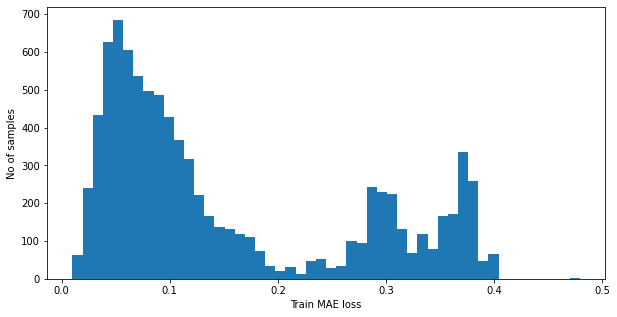

In [46]:
# Get train MAE loss.
train_pred = model.predict(X_train)
train_loss = np.mean(np.abs(train_pred - X_train), axis=1)

plt.figure(figsize = (10,5))
plt.hist(train_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

In [47]:
# Get reconstruction loss threshold.
threshold = np.max(train_loss)
print("Reconstruction error threshold: ", threshold)

Reconstruction error threshold:  0.47898763796995575


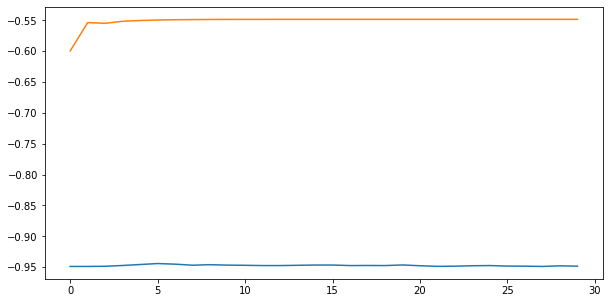

In [48]:
"""### Compare recontruction
Let's see how our model has recontructed the first sample. 
"""

# Checking how the first sequence is learnt
plt.figure(figsize = (10,5))
plt.plot(X_train[0])
plt.plot(train_pred[0])
plt.show()


In [49]:
import math
from sklearn.metrics import mean_squared_error
from pandas import DataFrame

# MAE on the test data:
y_pred = model.predict(X_test)
print('Predict shape:', y_pred.shape); print();
mae = np.mean(np.abs(y_pred - X_test), axis=1)

14/14 [==============================] - 0s 13ms/step
Predict shape: (437, 30, 1)



In [50]:
# reshaping prediction
pred = y_pred.reshape((y_pred.shape[0] * y_pred.shape[1]), y_pred.shape[2])
print('Prediction:', pred.shape); print();
print('Test data shape:', X_test.shape); print();


Prediction: (13110, 1)

Test data shape: (437, 30, 1)



In [51]:
# reshaping test data
X_test = X_test.reshape((X_test.shape[0] * X_test.shape[1]), X_test.shape[2])
print('Test data:', X_test.shape); print();

#Error Computation (To be solve)
errors = X_test - pred
print("Error:", errors.shape), print()


Test data: (13110, 1)

Error: (13110, 1)



(None, None)

In [52]:
#rmse on Test Data
RMSE = math.sqrt(mean_squared_error(X_test, pred))
print('Test RMSE: %.3f' % RMSE);

Test RMSE: 0.124


In [53]:
# Threshould Computation 
dist = np.linalg.norm(X_test - pred, axis=1)
scores = dist.copy()
print('Score:', scores.shape)
scores.sort()
cut_off = int(0.80 * len(scores))
print('Cutoff value:', cut_off)
threshold = scores[cut_off]
print('Threshold value:', threshold) 


Score: (13110,)
Cutoff value: 10488
Threshold value: 0.15648877076798717


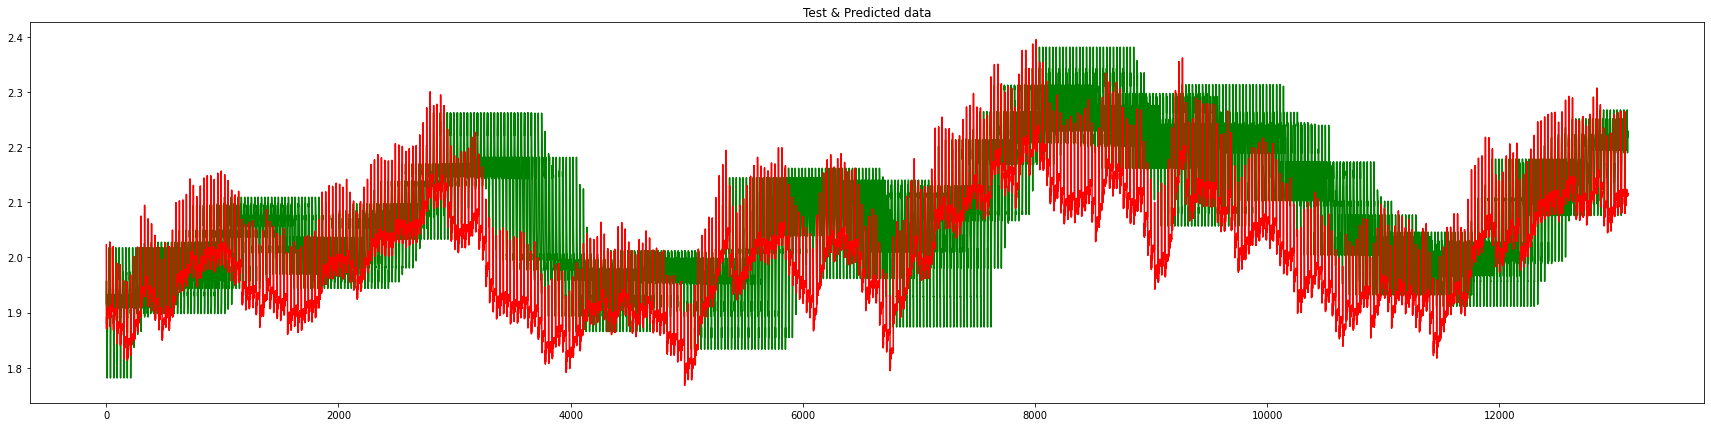

In [54]:
plt.figure(figsize= (30,7))
plt.plot(X_test, color = 'green')
plt.plot(pred, color = 'red')
plt.title("Test & Predicted data")
plt.show()

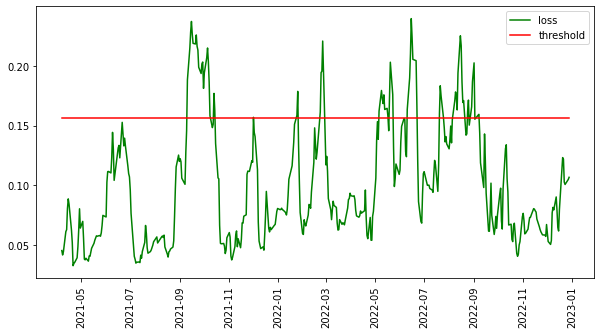

In [56]:
score = DataFrame(index=test[n_steps:].index)
score['loss'] = mae
score['threshold'] = threshold
score['anomaly'] = score['loss'] > score['threshold']
score['Close'] = test[n_steps:].Close

plt.figure(figsize = (10,5))
plt.plot(score.index, score['loss'], color = 'green', label='loss')
plt.plot(score.index, score['threshold'], color = 'r', label='threshold')
plt.xticks(rotation=90)
plt.legend();

In [57]:
#Anomalies Report Format
anomalies = score[score['anomaly'] == True]
x = DataFrame(anomalies.Close)
x = DataFrame(robust.inverse_transform(x))
x.index = anomalies.index
x.rename(columns = {0: 'inverse_price'}, inplace = True)
anomalies = anomalies.join(x, how = 'left')
anomalies = anomalies.drop(columns=['Close'], axis=1)
anomalies.tail(10) 


,loss,threshold,anomaly,inverse_price
Date,,,,
2022-08-18,0.169237,0.156489,True,166.770004
2022-08-19,0.170826,0.156489,True,169.309998
2022-08-24,0.161827,0.156489,True,165.580002
2022-08-25,0.171213,0.156489,True,167.130005
2022-08-29,0.165592,0.156489,True,163.000000
2022-08-30,0.186526,0.156489,True,162.429993
2022-08-31,0.194476,0.156489,True,161.339996
2022-09-01,0.202293,0.156489,True,165.339996
2022-09-06,0.158622,0.156489,True,163.179993


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



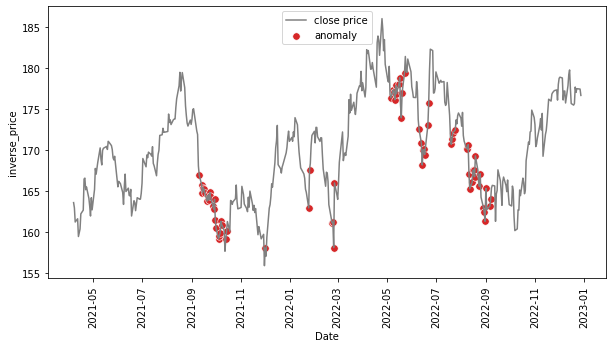

In [59]:
test[n_steps:].index

test_inv = DataFrame(robust.inverse_transform(test[n_steps:]))
test_inv.index = test[n_steps:].index
test_inv.rename(columns = {0: 'Close'}, inplace = True)
test_inv

plt.figure(figsize = (10,5))
plt.plot(test_inv.index, test_inv.Close, color = 'gray', label='close price');
sns.scatterplot(anomalies.index, anomalies['inverse_price'], color=sns.color_palette()[3], s=55, label='anomaly')
plt.xticks(rotation=90)
plt.legend(loc='upper center');

In [60]:
#Inverse Test Data:
test_inv = DataFrame(robust.inverse_transform(test[n_steps:]))
test_inv.index = test[n_steps:].index
test_inv.rename(columns = {0: 'Close'}, inplace = True)
test_inv 

,Close
Date,
2021-04-07,163.610001
2021-04-08,162.970001
2021-04-09,161.250000
2021-04-12,161.639999
2021-04-13,159.479996
...,...
2022-12-21,177.679993
2022-12-22,177.029999
2022-12-23,177.479996


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



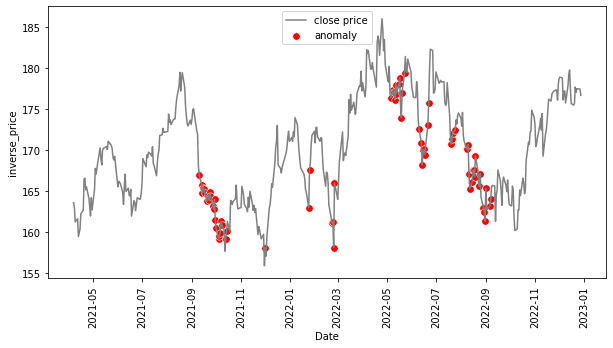

In [62]:
#Anomalies found in testing Data:
plt.figure(figsize = (10,5))
plt.plot(test_inv.index, test_inv.Close, color = 'gray', label='close price')
sns.scatterplot(anomalies.index, anomalies['inverse_price'], color='red', s=55, label='anomaly')
plt.xticks(rotation=90)
plt.legend(loc='upper center') 

